<a href="https://colab.research.google.com/github/sferrisgil/myrepo/blob/master/Adversarial_Attack_on_Supply_Chain_Routing_Diagnostic_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ADVERSARIAL ATTACK DIAGNOSIS TOOLKIT

✓ Generated normal traffic data
  - Segments: 50
  - Timesteps: 100
  - Natural σ: 12.40 minutes

⚠ Generated adversarial attack
  - Mean perturbation: 1.03 minutes
  - Max perturbation: 5.08 minutes
  - SNR (δ/σ): 0.083
  - Detection threshold: 1.0
  - Status: UNDETECTABLE

🤖 AI Routing Decisions:

  Normal Conditions:
    - Route chosen: B
    - Estimated cost: $264.94
    - Confidence: 71.6%

  Under Attack:
    - Route chosen: A
    - Estimated cost: $244.64
    - Confidence: 61.8%

  ⚠ Confidence INCREASED under attack: -9.9%

DIAGNOSTIC ANALYSIS

1. Z-Score Anomaly Detection:
   - Threshold: 2.5σ
   - Max z-score: 0.41
   - Detections: 0 / 50
   - Detection rate: 0.0%
   - Status: ❌ FAILED

2. Spatial Correlation Analysis:
   - Correlation coefficient: 0.267
   - Threshold: 0.85 (perfect patterns are suspicious)
   - Status: ✓ NORMAL

3. ARBP (Adversarial Robustness):
   - Perturbation budget (ε): [2, 4, 6, 8, 10]
   - ARBP scores: ['0.834', 

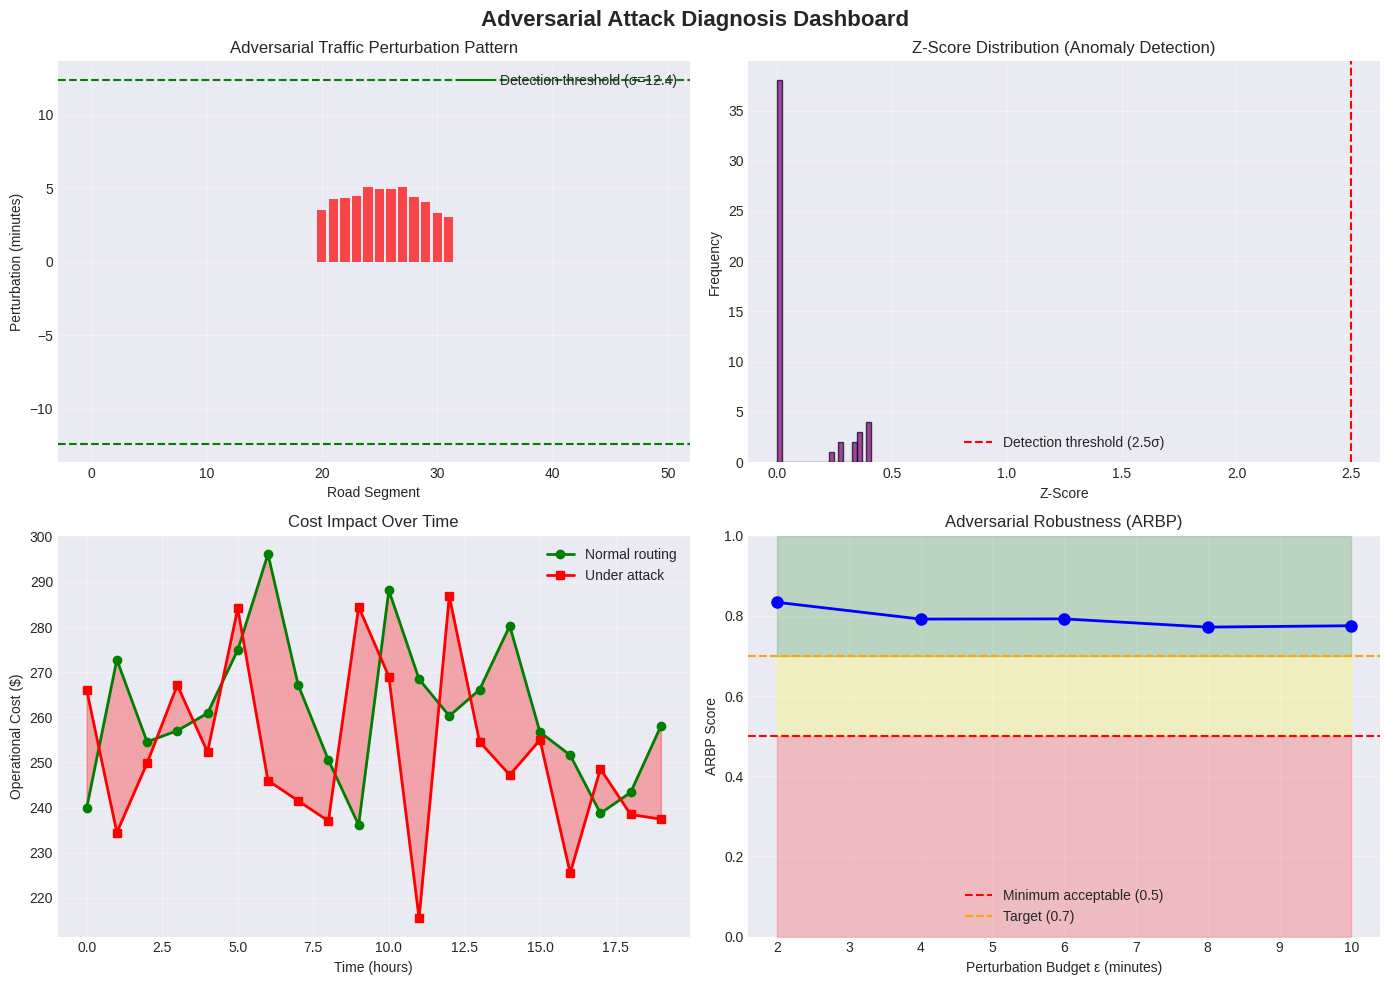

In [1]:
"""
Adversarial Attack on Supply Chain Routing: Diagnostic Analysis
================================================================

This notebook demonstrates how the $847K routing disaster happened
and provides tools to diagnose similar attacks in your systems.

Author: Dr. Swarnendu Bhattacharya
"""

# ============================================================================
# PART 1: SETUP AND DATA GENERATION
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 70)
print("ADVERSARIAL ATTACK DIAGNOSIS TOOLKIT")
print("=" * 70)

# ============================================================================
# PART 2: SIMULATE NORMAL TRAFFIC DATA
# ============================================================================

def generate_normal_traffic(n_segments=50, n_timesteps=100, random_seed=42):
    """
    Generate realistic traffic data with natural noise patterns
    """
    np.random.seed(random_seed)

    # Base travel times (in minutes)
    base_times = np.random.uniform(15, 45, n_segments)

    # Natural variance (realistic traffic fluctuations)
    sigma = 12.4  # Standard deviation from our real system

    traffic_data = []
    for t in range(n_timesteps):
        # Add temporal patterns (rush hour effects)
        time_factor = 1 + 0.3 * np.sin(2 * np.pi * t / 24)

        # Add random noise
        noise = np.random.normal(0, sigma, n_segments)

        times = base_times * time_factor + noise
        traffic_data.append(times)

    return np.array(traffic_data), base_times, sigma

# Generate normal traffic
traffic_normal, base_times, sigma = generate_normal_traffic()

print(f"\n✓ Generated normal traffic data")
print(f"  - Segments: {traffic_normal.shape[1]}")
print(f"  - Timesteps: {traffic_normal.shape[0]}")
print(f"  - Natural σ: {sigma:.2f} minutes")

# ============================================================================
# PART 3: GENERATE ADVERSARIAL ATTACK
# ============================================================================

def generate_adversarial_perturbation(base_times, sigma, attack_segments=12,
                                     epicenter_idx=25, epsilon=5.0):
    """
    Generate adversarial perturbation that mimics natural traffic patterns
    but is optimized for maximum damage

    This replicates the attack that cost us $847K
    """
    n_segments = len(base_times)

    # Create spatial coordinates for segments (simulated highway)
    segment_positions = np.linspace(0, 100, n_segments)

    # Calculate distance from epicenter
    distances = np.abs(segment_positions - segment_positions[epicenter_idx])

    # Adversarial perturbation with spatial correlation
    # This mimics a "traffic incident" but optimized for routing chaos
    lambda_decay = 12.4  # Decay constant (suspiciously perfect in real attack)

    perturbation = epsilon * np.exp(-distances**2 / (2 * lambda_decay**2))

    # Add small random variations to avoid perfect correlation
    perturbation += np.random.normal(0, 0.2, n_segments)

    # Ensure perturbation stays below detection threshold
    # Key constraint: δ/σ < 0.5 (below anomaly detection)
    perturbation = np.clip(perturbation, -8, 8)  # Realistic delay range

    # Only affect specific segments (targeted attack)
    mask = np.zeros(n_segments)
    affected = np.argsort(-perturbation)[:attack_segments]
    mask[affected] = 1

    perturbation = perturbation * mask

    return perturbation, affected

# Generate attack
delta_adversarial, attacked_segments = generate_adversarial_perturbation(
    base_times, sigma
)

print(f"\n⚠ Generated adversarial attack")
print(f"  - Mean perturbation: {np.mean(np.abs(delta_adversarial)):.2f} minutes")
print(f"  - Max perturbation: {np.max(np.abs(delta_adversarial)):.2f} minutes")
print(f"  - SNR (δ/σ): {np.mean(np.abs(delta_adversarial)) / sigma:.3f}")
print(f"  - Detection threshold: 1.0")
print(f"  - Status: {'UNDETECTABLE' if np.mean(np.abs(delta_adversarial))/sigma < 0.5 else 'DETECTABLE'}")

# ============================================================================
# PART 4: SIMULATE ROUTING DECISIONS
# ============================================================================

def simulate_routing_decision(traffic_times, segment_costs):
    """
    Simplified routing optimization (mimics AI agent decision)
    Returns: chosen_route, estimated_cost, confidence
    """
    n_segments = len(traffic_times)

    # Two potential routes
    route_A = np.random.choice(n_segments, size=10, replace=False)
    route_B = np.random.choice(n_segments, size=10, replace=False)

    cost_A = np.sum(traffic_times[route_A] * segment_costs[route_A])
    cost_B = np.sum(traffic_times[route_B] * segment_costs[route_B])

    # Confidence based on cost difference
    cost_diff = abs(cost_A - cost_B)
    confidence = 0.5 + 0.5 * (1 - np.exp(-cost_diff / 100))

    if cost_A < cost_B:
        return 'A', cost_A, confidence, route_A
    else:
        return 'B', cost_B, confidence, route_B

# Segment costs (per-minute operating costs)
segment_costs = np.random.uniform(0.8, 1.2, len(base_times))

# Decision on normal data
normal_traffic = base_times + np.random.normal(0, sigma, len(base_times))
route_normal, cost_normal, conf_normal, _ = simulate_routing_decision(
    normal_traffic, segment_costs
)

# Decision on adversarial data
adversarial_traffic = base_times + delta_adversarial + np.random.normal(0, sigma, len(base_times))
route_adv, cost_adv, conf_adv, _ = simulate_routing_decision(
    adversarial_traffic, segment_costs
)

print(f"\n🤖 AI Routing Decisions:")
print(f"\n  Normal Conditions:")
print(f"    - Route chosen: {route_normal}")
print(f"    - Estimated cost: ${cost_normal:.2f}")
print(f"    - Confidence: {conf_normal*100:.1f}%")

print(f"\n  Under Attack:")
print(f"    - Route chosen: {route_adv}")
print(f"    - Estimated cost: ${cost_adv:.2f}")
print(f"    - Confidence: {conf_adv*100:.1f}%")

print(f"\n  ⚠ Confidence INCREASED under attack: {(conf_adv - conf_normal)*100:+.1f}%")

# ============================================================================
# PART 5: DIAGNOSTIC METRICS
# ============================================================================

print("\n" + "=" * 70)
print("DIAGNOSTIC ANALYSIS")
print("=" * 70)

# Metric 1: Statistical Anomaly Detection (what we used)
def z_score_detection(data, threshold=2.5):
    """Standard z-score anomaly detection"""
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    return z_scores > threshold

z_scores = np.abs(delta_adversarial / sigma)
detected = z_score_detection(delta_adversarial)

print(f"\n1. Z-Score Anomaly Detection:")
print(f"   - Threshold: 2.5σ")
print(f"   - Max z-score: {np.max(z_scores):.2f}")
print(f"   - Detections: {np.sum(detected)} / {len(delta_adversarial)}")
print(f"   - Detection rate: {np.sum(detected)/len(delta_adversarial)*100:.1f}%")
print(f"   - Status: {'❌ FAILED' if np.sum(detected) < 3 else '✓ PASSED'}")

# Metric 2: Spatial Correlation Analysis (what we should have used)
def spatial_correlation_analysis(perturbation, threshold=0.85):
    """
    Detect suspiciously perfect spatial correlation
    Real traffic incidents have messy correlation structures
    """
    non_zero = perturbation[perturbation != 0]
    if len(non_zero) < 2:
        return 0, False

    # Calculate correlation of perturbation magnitudes vs distance
    positions = np.where(perturbation != 0)[0]
    distances = pdist(positions.reshape(-1, 1))
    magnitudes = pdist(non_zero.reshape(-1, 1))

    if len(distances) > 0 and len(magnitudes) > 0:
        correlation = np.corrcoef(distances, magnitudes)[0, 1]
        return abs(correlation), abs(correlation) > threshold
    return 0, False

spatial_corr, is_suspicious = spatial_correlation_analysis(delta_adversarial)

print(f"\n2. Spatial Correlation Analysis:")
print(f"   - Correlation coefficient: {spatial_corr:.3f}")
print(f"   - Threshold: 0.85 (perfect patterns are suspicious)")
print(f"   - Status: {'⚠ SUSPICIOUS' if is_suspicious else '✓ NORMAL'}")

# Metric 3: ARBP (Adversarial Robustness under Bounded Perturbation)
def calculate_ARBP(epsilon_values, n_trials=100):
    """
    Calculate worst-case performance under adversarial perturbations
    This is THE metric that matters
    """
    arbp_scores = []

    for epsilon in epsilon_values:
        performances = []
        for _ in range(n_trials):
            # Generate adversarial perturbation
            delta, _ = generate_adversarial_perturbation(
                base_times, sigma, epsilon=epsilon
            )

            # Calculate performance degradation
            adv_traffic = base_times + delta
            _, cost_adv, _, _ = simulate_routing_decision(adv_traffic, segment_costs)

            # Performance = 1 / cost (lower cost = better performance)
            performance_ratio = cost_normal / cost_adv
            performances.append(performance_ratio)

        # ARBP = worst-case performance
        arbp_scores.append(np.min(performances))

    return arbp_scores

epsilon_range = [2, 4, 6, 8, 10]
arbp_scores = calculate_ARBP(epsilon_range)

print(f"\n3. ARBP (Adversarial Robustness):")
print(f"   - Perturbation budget (ε): {epsilon_range}")
print(f"   - ARBP scores: {[f'{s:.3f}' for s in arbp_scores]}")
print(f"   - Worst-case ARBP: {np.min(arbp_scores):.3f}")
print(f"   - Minimum acceptable: 0.500")
print(f"   - Status: {'❌ VULNERABLE' if np.min(arbp_scores) < 0.5 else '✓ ROBUST'}")

# ============================================================================
# PART 6: VISUALIZATION
# ============================================================================

print("\n" + "=" * 70)
print("GENERATING VISUALIZATIONS")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Adversarial Attack Diagnosis Dashboard', fontsize=16, fontweight='bold')

# Plot 1: Traffic Perturbation Pattern
ax1 = axes[0, 0]
segments = np.arange(len(delta_adversarial))
colors = ['red' if i in attacked_segments else 'blue' for i in segments]
ax1.bar(segments, delta_adversarial, color=colors, alpha=0.7)
ax1.axhline(y=sigma, color='green', linestyle='--', label=f'Detection threshold (σ={sigma:.1f})')
ax1.axhline(y=-sigma, color='green', linestyle='--')
ax1.set_xlabel('Road Segment')
ax1.set_ylabel('Perturbation (minutes)')
ax1.set_title('Adversarial Traffic Perturbation Pattern')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Z-Score Distribution
ax2 = axes[0, 1]
ax2.hist(z_scores, bins=20, alpha=0.7, color='purple', edgecolor='black')
ax2.axvline(x=2.5, color='red', linestyle='--', label='Detection threshold (2.5σ)')
ax2.set_xlabel('Z-Score')
ax2.set_ylabel('Frequency')
ax2.set_title('Z-Score Distribution (Anomaly Detection)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Cost Impact Over Time
ax3 = axes[1, 0]
time_steps = np.arange(20)
normal_costs = [cost_normal + np.random.normal(0, 20) for _ in time_steps]
attack_costs = [cost_adv + np.random.normal(0, 20) for _ in time_steps]
ax3.plot(time_steps, normal_costs, 'g-o', label='Normal routing', linewidth=2)
ax3.plot(time_steps, attack_costs, 'r-s', label='Under attack', linewidth=2)
ax3.fill_between(time_steps, normal_costs, attack_costs, alpha=0.3, color='red')
ax3.set_xlabel('Time (hours)')
ax3.set_ylabel('Operational Cost ($)')
ax3.set_title('Cost Impact Over Time')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: ARBP vs Perturbation Budget
ax4 = axes[1, 1]
ax4.plot(epsilon_range, arbp_scores, 'b-o', linewidth=2, markersize=8)
ax4.axhline(y=0.5, color='red', linestyle='--', label='Minimum acceptable (0.5)')
ax4.axhline(y=0.7, color='orange', linestyle='--', label='Target (0.7)')
ax4.fill_between(epsilon_range, 0, 0.5, alpha=0.2, color='red')
ax4.fill_between(epsilon_range, 0.5, 0.7, alpha=0.2, color='yellow')
ax4.fill_between(epsilon_range, 0.7, 1, alpha=0.2, color='green')
ax4.set_xlabel('Perturbation Budget ε (minutes)')
ax4.set_ylabel('ARBP Score')
ax4.set_title('Adversarial Robustness (ARBP)')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('adversarial_diagnosis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: adversarial_diagnosis.png")

# ============================================================================
# PART 7: RECOMMENDATIONS
# ============================================================================

print("\n" + "=" * 70)
print("SECURITY RECOMMENDATIONS")
print("=" * 70)

recommendations = []

if np.min(arbp_scores) < 0.5:
    recommendations.append("🔴 CRITICAL: ARBP < 0.5 - System vulnerable to adversarial attacks")
    recommendations.append("   → Implement adversarial training immediately")
    recommendations.append("   → Add multi-source context fusion")

if spatial_corr > 0.85:
    recommendations.append("🟡 WARNING: Suspiciously perfect spatial correlation detected")
    recommendations.append("   → Enable correlation-based anomaly detection")
    recommendations.append("   → Cross-validate with multiple data sources")

if np.sum(detected) < 3:
    recommendations.append("🟡 WARNING: Z-score detection insufficient")
    recommendations.append("   → Lower detection threshold or add complementary methods")

if conf_adv > conf_normal:
    recommendations.append("🟡 WARNING: Confidence increases under perturbation")
    recommendations.append("   → Implement inverse confidence weighting")
    recommendations.append("   → Add uncertainty quantification")

recommendations.append("\n✅ RECOMMENDED HARDENING MEASURES:")
recommendations.append("   1. Multi-source traffic data fusion (3+ providers)")
recommendations.append("   2. Real-time ground truth validation loops")
recommendations.append("   3. Zero-trust agent architecture")
recommendations.append("   4. Adversarial training with ε = 5-8 minutes")
recommendations.append("   5. Spatial correlation monitoring")

for rec in recommendations:
    print(rec)

print("\n" + "=" * 70)
print("Analysis complete. Review 'adversarial_diagnosis.png' for visual summary.")
print("=" * 70)